<a href="https://colab.research.google.com/github/PRABHALATEJASWI/FEYNN-LAB2/blob/main/Experimentalfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from PIL import Image
import glob

In [3]:
files = glob.glob('C:/Users/red/Downloads/archive/model/Labelled/*/*')

In [4]:
files_reshape = list(map(lambda x: x.replace('/Labelled\\', '/Resized\\'), files))

In [5]:
basewidth = 300
for file, file_save in zip(files, files_reshape):
    img = Image.open(file)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    img.save(file_save)

In [7]:
from skimage.morphology import binary_closing, binary_opening, erosion


In [8]:
files_bgremoved = list(map(lambda x: x.replace('/Labelled\\', '/BGRemoved\\'), files))

In [10]:
import numpy as np
selem = np.zeros((25, 25))

ci,cj=12, 12
cr=13

# Create index arrays to z
I,J=np.meshgrid(np.arange(selem.shape[0]),np.arange(selem.shape[1]))

# calculate distance of all points to centre
dist=np.sqrt((I-ci)**2+(J-cj)**2)

# Assign value of 1 to those points where dist<cr:
selem[np.where(dist<=cr)]=1

In [11]:
%matplotlib inline
import numpy as np
from scipy import ndimage

# fig, ax = plt.subplots(20,2, figsize=(10,80))
idx = 0
for file, file_save in zip(files, files_bgremoved):
    bg_frac = 0
    thres = 220
    img = Image.open(file)
    im_arr = np.array(img)
#     ax[idx, 0].imshow(im_arr)
    R = im_arr[:, :, 0]
    G = im_arr[:, :, 1]
    B = im_arr[:, :, 2]
    while bg_frac < 0.6:
        bg_mask = ((R>thres) | (B>thres))# & (G < 100)
        bg_frac = bg_mask.sum()/len(bg_mask.flatten())
        thres -= 5
    # we use opening first since our mask is reversed (the foreground and background are reversed here)
    bg_mask = binary_closing(erosion(binary_opening(bg_mask, selem), np.ones((3, 3))), np.ones((5,5)))

    #Get biggest blob
    label, num_label = ndimage.label(~bg_mask)
    size = np.bincount(label.ravel())
    biggest_label = size[1:].argmax() + 1
    bg_mask = label == biggest_label

    im_arr[~bg_mask, 0] = 255
    im_arr[~bg_mask, 1] = 255
    im_arr[~bg_mask, 2] = 255

    img = Image.fromarray(im_arr)
    img.save(file_save)
    idx+=1

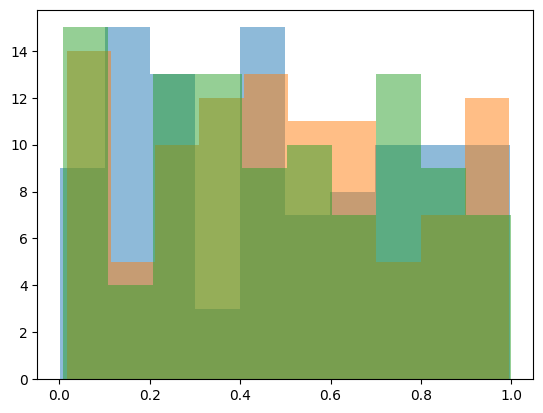

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
R = np.random.rand(100)  # Example random data for the red channel
G = np.random.rand(100)  # Example random data for the green channel
B = np.random.rand(100)  # Example random data for the blue channel

# Plot histograms
plt.hist(R.flatten(), alpha=0.5)
plt.hist(G.flatten(), alpha=0.5)
plt.hist(B.flatten(), alpha=0.5)

plt.show()


In [14]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = ('C:/Users/red/Downloads/archive/model/BGRemoved')
os.makedirs(base_dir, exist_ok=True)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint('VGG16.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

In [17]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")
# datagen = ImageDataGenerator(rescale=1./255)

def extract_features(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(preprocess_input(inputs_batch))
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except ValueError:
            break
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
conv_base.trainable = True
for layer in conv_base.layers:
    layer.trainable = True

In [21]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))

In [25]:
from tensorflow.keras.optimizers import Adam

INIT_LR = 1e-1
EPOCHS = 30

opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])



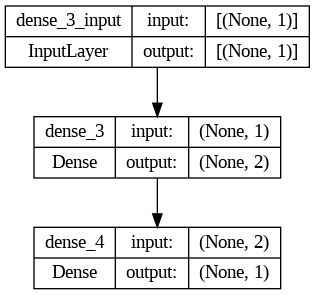

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\1000246125\\AppData\\Local\\Continuum\\anaconda3\\Library\\bin'
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest", validation_split=0.3)
batch_size = 32

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [31]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [32]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.2))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))

In [35]:
def extract_features19(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base19.predict(preprocess_input(inputs_batch))
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except ValueError:
            break
        if i==0:
            print("one down")
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


In [36]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

conv_base19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [38]:
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest", validation_split=0.3)
batch_size = 32

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [39]:
from tensorflow.keras.applications.xception import Xception, preprocess_input
xception_base = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

83683744/83683744 [==============================] - 0s 0us/step


In [40]:
# datagen = ImageDataGenerator(rescale=1./255)

def extract_features_xception(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = xception_base.predict(preprocess_input(inputs_batch))
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except ValueError:
            break
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [44]:


model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 2048))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.35))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))

In [45]:
def extract_features_resnet(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = resnet_base.predict(preprocess_input(inputs_batch))
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        except ValueError:
            break
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [51]:
{
  "Bacterial_leaf_blight": "Hispa",
  "blast": "LeafBlast",
  "brownspot": "BrownSpot"
}

{'Bacterial_leaf_blight': 'Hispa',
 'blast': 'LeafBlast',
 'brownspot': 'BrownSpot'}